In [25]:
import torch
from torch.utils.data import DataLoader

from model.encoder import Encoder
from model.decoder import Decoder
from datautil.waymo_dataset import WaymoDataset, waymo_collate_fn

COLORS = [(0,0,255), (255,0,255), (180,180,0), (143,143,188), (0,100,0), (128,128,0)]

bs = 4

dataset = WaymoDataset('data/single_sample/data', 'data/single_sample/idxs', None)
dloader = DataLoader(dataset, batch_size=bs, collate_fn=waymo_collate_fn, num_workers=1)
batch = next(iter(dloader))

(states_batch, agents_batch_mask, states_padding_batch, 
                (states_hidden_BP_batch, states_hidden_CBP_batch, states_hidden_GDP_batch), 
                    roadgraph_feat_batch, roadgraph_padding_batch, traffic_light_feat_batch, traffic_light_padding_batch,
                        agent_rg_mask, agent_traffic_mask, (num_agents_accum, num_rg_accum, num_tl_accum),
                            sdc_masks, center_ps) = batch.values()

In [26]:
print(states_batch.shape)
print(agents_batch_mask.shape)
print(states_padding_batch.shape)
print(states_hidden_BP_batch.shape)
print(num_agents_accum, num_rg_accum, num_tl_accum)
print(roadgraph_feat_batch.shape)
print(roadgraph_padding_batch.shape)
print(traffic_light_feat_batch.shape)

torch.Size([165, 10, 9])
torch.Size([165, 165])
torch.Size([165, 10])
torch.Size([165, 10])
[  0  25  45 129 165] [   0 1400 2800 4200 5600] [0 0 6 6 6]
torch.Size([5600, 10, 6])
torch.Size([5600, 10])
torch.Size([6, 10, 3])


In [27]:
# roadgraph_feat_[0,0,:]
import numpy as np
import cv2
from datautil.waymo_dataset import xy_to_pixel

width = 150
empty_mask = np.zeros((width,width))

i = 0

start = num_agents_accum[i]
end = num_agents_accum[i+1]
states_, states_padding_, states_hidden_BP_ = states_batch[start:end], states_padding_batch[start:end], states_hidden_BP_batch[start:end]
roadgraph_feat_, roadgraph_padding_ = roadgraph_feat_batch[1400*i:1400*(i+1)], roadgraph_padding_batch[1400*i:1400*(i+1)]
roadgraph_type_, roadgraph_id_ = roadgraph_feat_[...,-2], roadgraph_feat_[...,-1]
traffic_light_, traffic_light_padding_ = traffic_light_feat_batch[num_tl_accum[i]:num_tl_accum[i+1]], traffic_light_padding_batch[num_tl_accum[i]:num_tl_accum[i+1]]
center_p = center_ps[i]

# sdc_mask = data['state/is_sdc'] > 0.
# center_x, center_y = current_states[sdc_mask][0,0,:2]

ctline_mask = (roadgraph_feat_[...,-2]==2)[:,0]

drivable_area = empty_mask.copy()
centerlines = empty_mask.copy()

In [81]:
import numpy as np
import cv2
# from datautil.waymo_dataset import xy_to_pixel

def xy_to_pixel(xy, width):
    xy[:,1] *= -1
    xy += int(width/2)
    mask_x = (xy[:,0] <= width)*(xy[:,0]>=0)
    mask_y = (xy[:,1] <= width)*(xy[:,1]>=0)

    xy = xy[mask_x*mask_y]

    return xy


width = 500
empty_mask = np.zeros((width,width))
total_empty = np.zeros((width,width,3))
current_step=3

scene_imgs = []

for i in range(len(num_agents_accum)-1):
    total_empty_ = total_empty.copy()
    start = num_agents_accum[i]
    end = num_agents_accum[i+1]
    states_, states_padding_, states_hidden_BP_ = states_batch[start:end], states_padding_batch[start:end], states_hidden_BP_batch[start:end]
    roadgraph_feat_, roadgraph_padding_ = roadgraph_feat_batch[1400*i:1400*(i+1)], roadgraph_padding_batch[1400*i:1400*(i+1)]
    roadgraph_type_, roadgraph_id_ = roadgraph_feat_[:,current_step,-2], roadgraph_feat_[:,current_step,-1]
    traffic_light_, traffic_light_padding_ = traffic_light_feat_batch[num_tl_accum[i]:num_tl_accum[i+1]], traffic_light_padding_batch[num_tl_accum[i]:num_tl_accum[i+1]]
    center_p = center_ps[i]

    
    # sdc_mask = data['state/is_sdc'] > 0.
    # center_x, center_y = current_states[sdc_mask][0,0,:2]

    ctline_mask = (roadgraph_feat_[...,-2]==2)[:,0]

    drivable_area = empty_mask.copy()
    centerlines = empty_mask.copy()

    

    # Road 
    lane_mask = torch.zeros(ctline_mask.shape, dtype=torch.bool)
    for type_ in [6,7,8,9,10,11,12,13,14]:
        lane_mask += (roadgraph_type_==type_)

    lanes = empty_mask.copy()

    for id_ in np.unique(roadgraph_id_[lane_mask]):
        lane_id_mask = lane_mask*(roadgraph_id_==id_)
        lane_xy = roadgraph_feat_[:,current_step,:2][lane_id_mask] - center_p
        lane_xy *= (width/2)
        lane_xy = xy_to_pixel(lane_xy,width)

        polygon = np.array([lane_xy.numpy()], np.int32)
        # polygon = lane_xy.numpy().astype(np.int32)
        cv2.polylines(lanes, polygon, isClosed=False, color=1, thickness=1)

        # cv2.polylines(total_empty_, polygon, isClosed=False, color=(125,125,125), thickness=20)

    for id_ in np.unique(roadgraph_id_[ctline_mask]):
        ctline_id_mask = ctline_mask*(roadgraph_id_==id_)
        ctline_xy = roadgraph_feat_[:,current_step,:2][ctline_id_mask] - center_p
        ctline_xy *= (width/2)
        ctline_xy = xy_to_pixel(ctline_xy,width)

        polygon = np.array([ctline_xy.numpy()], np.int32)

        cv2.polylines(total_empty_, polygon, isClosed=False, color=(255,255,255), thickness=20)
        # cv2.polylines(total_empty_, polygon, isClosed=False, color=(80,80,80), thickness=1)

    for si_, (s_, sp_, sh_) in enumerate(zip(states_, states_padding_, states_hidden_BP_)):
        s__ = s_[:,:2].clone() * (width/2)
        s__ = xy_to_pixel(s__, width)
        # s__ = s__[~sp_]
        if not sp_[current_step]:
            polygon = np.array([s__[~sp_].numpy()], np.int32)
            cv2.polylines(total_empty_, polygon, isClosed=False, color=COLORS[si_%len(COLORS)], thickness=2)
            cv2.circle(img=total_empty_, center=tuple(s__[current_step].numpy().astype(np.int32)), radius=3, color=COLORS[si_%len(COLORS)], thickness=cv2.FILLED)
        else:
            polygon = np.array([s__[~sp_].numpy()], np.int32)
            cv2.polylines(total_empty_, polygon, isClosed=False, color=(100,100,100), thickness=2)
        
        # # print(si_, s_[:,:2], s__.numpy().astype(np.int32))
        # for i_ in range(len(s_)):
        # # [cv2.circle(img=total_empty_, center=tuple(xy.numpy().astype(np.int32)), radius=3, color=COLORS[si_], thickness=cv2.FILLED) for xy in s__]
        #     if not sp_[i_]:
        #         # print(s__[i_])
        #         cv2.circle(img=total_empty_, center=tuple(s__[i_].numpy().astype(np.int32)), radius=3, color=COLORS[si_%len(COLORS)], thickness=cv2.FILLED)



    red_mask = ((traffic_light_[:,current_step,-1] == 4) + (traffic_light_[:,current_step,-1] == 7))
    yellow_mask = ((traffic_light_[:,current_step,-1] == 5) + (traffic_light_[:,current_step,-1] == 8))
    green_mask = traffic_light_[:,current_step,-1] == 6

    # arrow_red_mask = traffic_light_states_current[:,0,0] == 1
    # arrow_yellow_mask = traffic_light_states_current[:,0,0] == 2
    # arrow_green_mask = traffic_light_states_current[:,0,0] == 3

    red_xy = xy_to_pixel(traffic_light_[:,current_step,:2][red_mask].clone() - center_p, width).numpy()#*(width/2)
    yellow_xy = xy_to_pixel(traffic_light_[:,current_step,:2][yellow_mask].clone() - center_p, width).numpy()#*(width/2)
    green_xy = xy_to_pixel(traffic_light_[:,current_step,:2][green_mask].clone() - center_p, width).numpy()#*(width/2)

    red_lights = empty_mask.copy()
    yellow_lights = empty_mask.copy()
    green_lights = empty_mask.copy()

    # [cv2.circle(img=red_lights, center=tuple(xy.astype(np.int32)), radius=1, color=1, thickness=cv2.FILLED) for xy in red_xy]
    # [cv2.circle(img=yellow_lights, center=tuple(xy.astype(np.int32)), radius=1, color=1, thickness=cv2.FILLED) for xy in yellow_xy]
    # [cv2.circle(img=green_lights, center=tuple(xy.astype(np.int32)), radius=1, color=1, thickness=cv2.FILLED) for xy in green_xy]

    [cv2.circle(img=total_empty_, center=tuple(xy.astype(np.int32)), radius=5, color=(0,0,255), thickness=1) for xy in red_xy]
    [cv2.circle(img=total_empty_, center=tuple(xy.astype(np.int32)), radius=5, color=(255,255,0), thickness=1) for xy in yellow_xy]
    [cv2.circle(img=total_empty_, center=tuple(xy.astype(np.int32)), radius=5, color=(0,255,0), thickness=1) for xy in green_xy]

    scene_imgs.append(total_empty_)

    # scene_img = np.stack((drivable_area,centerlines,lanes,red_lights,yellow_lights,green_lights))


In [82]:
s__.shape
sp_.shape

torch.Size([10])

In [83]:
width

500

In [84]:
print(total_empty_.max())
for i in range(len(scene_imgs)):
    cv2.imwrite(f'output_{i}.png', scene_imgs[i])

255.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


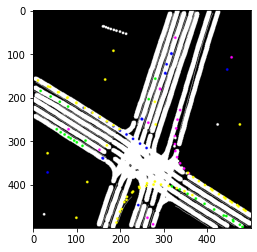

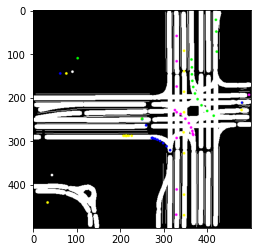

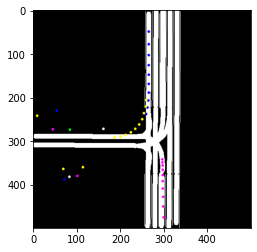

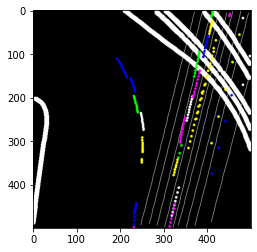

In [8]:
import matplotlib.pyplot as plt
for img_ in scene_imgs:
    plt.figure()
    plt.imshow(img_)

In [16]:
import numpy as np
import cv2
from datautil.waymo_dataset import xy_to_pixel

width = 150
empty_mask = np.zeros((width,width))

for data in batch:
    # State of Agents
    vehicle_mask = (data['state/type']==1)

    past_states = np.stack((data['state/past/x'],data['state/past/y'],data['state/past/bbox_yaw'],
                                data['state/past/velocity_x'],data['state/past/velocity_y'],data['state/past/vel_yaw'],
                                    data['state/past/width'],data['state/past/length'],data['state/past/timestamp_micros']), axis=-1)
    past_states_valid = data['state/past/valid'] > 0.
    current_states = np.stack((data['state/current/x'],data['state/current/y'],data['state/current/bbox_yaw'],
                                data['state/current/velocity_x'],data['state/current/velocity_y'],data['state/current/vel_yaw'],
                                    data['state/current/width'],data['state/current/length'],data['state/current/timestamp_micros']), axis=-1)
    current_states_valid = data['state/current/valid'] > 0.
    future_states = np.stack((data['state/future/x'],data['state/future/y'],data['state/future/bbox_yaw'],
                                data['state/future/velocity_x'],data['state/future/velocity_y'],data['state/future/vel_yaw'],
                                    data['state/future/width'],data['state/future/length'],data['state/future/timestamp_micros']), axis=-1)
    future_states_valid = data['state/future/valid'] > 0.

    states_feat = np.concatenate((past_states,current_states,future_states),axis=1)
    states_valid = np.concatenate((past_states_valid,current_states_valid,future_states_valid),axis=1)
    states_any_mask = np.sum(states_valid,axis=1) > 0

    states_feat = states_feat[states_any_mask*vehicle_mask]
    states_padding_mask = states_valid[states_any_mask*vehicle_mask]
    
    # basic_mask = np.zeros((len(states_feat),91)).astype(np.bool_)
    states_hidden_mask_BP = np.ones((len(states_feat),91)).astype(np.bool_)
    states_hidden_mask_BP[:,:12] = False
    sdvidx = np.where(data['state/is_sdc'][states_any_mask] == 1)[0][0]
    states_hidden_mask_CBP = np.zeros((len(states_feat),91)).astype(np.bool_)
    states_hidden_mask_CBP[:,:12] = False
    states_hidden_mask_CBP[sdvidx-1,:] = False
    states_hidden_mask_GDP = np.zeros((len(states_feat),91)).astype(np.bool_)
    states_hidden_mask_GDP[:,:12] = False
    states_hidden_mask_GDP[sdvidx-1,-1] = False
    # states_hidden_mask_CDP = np.zeros((len(states_feat),91)).astype(np.bool_)

    num_agents = np.append(num_agents, len(states_feat))

    roadgraph_xyz = data['roadgraph_samples/xyz']
    roadgraph_type = data['roadgraph_samples/type']
    roadgraph_id = data['roadgraph_samples/id']

    # Dynamic Road Graph
    traffic_light_states_current = np.stack((data['traffic_light_state/current/state'].T,data['traffic_light_state/current/x'].T,data['traffic_light_state/current/y'].T),axis=-1)
    traffic_light_valid_current = data['traffic_light_state/current/valid'].T > 0.

    '''
    SDV-Centered Rasterized Images : [6,500,500]
    
    6-Channel Input : 
        0: drivable area
        1: centerlines
        2: road line
        3: red lights
        4: yellow lights
        5: green lights 
    
    (Optional) : add 3 more channel -> arrow red light, arrow yellow light, arrow green light

    '''
    sdc_mask = data['state/is_sdc'] > 0.
    center_x, center_y = current_states[sdc_mask][0,0,:2]

    ctline_mask = (roadgraph_type==2)[:,0]

    drivable_area = empty_mask.copy()
    centerlines = empty_mask.copy()

    for id_ in np.unique(roadgraph_id[ctline_mask]):
        ctline_id_mask = ctline_mask*(roadgraph_id==id_)[:,0]
        ctline_xy = roadgraph_xyz[ctline_id_mask][:,:2] - np.array([center_x,center_y])
        ctline_xy = xy_to_pixel(ctline_xy,width)

        polygon = np.array([ctline_xy], np.int32)
        cv2.polylines(drivable_area, polygon, isClosed=False, color=1, thickness=5)
        cv2.polylines(centerlines, polygon, isClosed=False, color=1, thickness=1)

    # Road 
    lane_mask = np.zeros(ctline_mask.shape).astype(np.bool_)
    for type_ in [6,7,8,9,10,11,12,13,14]:
        lane_mask += (roadgraph_type==type_)[:,0]

    lanes = empty_mask.copy()

    for id_ in np.unique(roadgraph_id[lane_mask]):
        lane_id_mask = lane_mask*(roadgraph_id==id_)[:,0]
        lane_xy = roadgraph_xyz[lane_id_mask][:,:2] - np.array([center_x,center_y])
        lane_xy = xy_to_pixel(lane_xy,width)

        polygon = np.array([lane_xy], np.int32)
        cv2.polylines(lanes, polygon, isClosed=False, color=1, thickness=1)


    red_mask = ((traffic_light_states_current[:,0,0] == 4) + (traffic_light_states_current[:,0,0] == 7))
    yellow_mask = ((traffic_light_states_current[:,0,0] == 5) + (traffic_light_states_current[:,0,0] == 8))
    green_mask = traffic_light_states_current[:,0,0] == 6

    # arrow_red_mask = traffic_light_states_current[:,0,0] == 1
    # arrow_yellow_mask = traffic_light_states_current[:,0,0] == 2
    # arrow_green_mask = traffic_light_states_current[:,0,0] == 3

    red_xy = xy_to_pixel(traffic_light_states_current[:,0,1:][red_mask] - np.array([center_x,center_y]), width)
    yellow_xy = xy_to_pixel(traffic_light_states_current[:,0,1:][yellow_mask] - np.array([center_x,center_y]), width)
    green_xy = xy_to_pixel(traffic_light_states_current[:,0,1:][green_mask] - np.array([center_x,center_y]), width)

    red_lights = empty_mask.copy()
    yellow_lights = empty_mask.copy()
    green_lights = empty_mask.copy()

    [cv2.circle(img=red_lights, center=tuple(xy.astype(np.int32)), radius=1, color=1, thickness=cv2.FILLED) for xy in red_xy]
    [cv2.circle(img=yellow_lights, center=tuple(xy.astype(np.int32)), radius=1, color=1, thickness=cv2.FILLED) for xy in yellow_xy]
    [cv2.circle(img=green_lights, center=tuple(xy.astype(np.int32)), radius=1, color=1, thickness=cv2.FILLED) for xy in green_xy]

    scene_img = np.stack((drivable_area,centerlines,lanes,red_lights,yellow_lights,green_lights))

    # filter out vehicle located outside boundary 
    states_feat[:,:,:2] = states_feat[:,:,:2] - np.array([center_x,center_y])
    agent_xy_mask = (-width/2 <= states_feat[:,10,:2])*(states_feat[:,10,:2] <= width/2)
    agent_xy_mask = agent_xy_mask[:,0]*agent_xy_mask[:,1]
    states_feat = states_feat[agent_xy_mask]

    states_padding_mask = states_padding_mask[agent_xy_mask]
    states_hidden_mask_BP = states_hidden_mask_BP[agent_xy_mask]
    states_hidden_mask_CBP = states_hidden_mask_CBP[agent_xy_mask]
    states_hidden_mask_GDP = states_hidden_mask_GDP[agent_xy_mask]

    # make target occupancy map for each agent
    tgt_img = np.zeros((len(states_feat),width,width))
    for i, agent_xy in enumerate(states_feat[:,10:,:2]):
        agent_xy = xy_to_pixel(agent_xy,width)
        cv2.polylines(tgt_img[i],[agent_xy.astype(np.int32)],isClosed=False,color=1,thickness=1)

    # normalize coordinate
    states_feat[:,10,:2] /= (width/2)       # normalize [-width/2,width/2] to [-1,1]
    # agent start point and end point 
    # 4-channel : start_x, start_y, end_x, end_y
    agent_points = np.concatenate((states_feat[:,10,:2],states_feat[:,-1,:2]),axis=-1)

out = (scene_img, tgt_img, agent_points, states_feat, states_padding_mask, agent_batch_mask, 
        (states_hidden_mask_BP,states_hidden_mask_CBP,states_hidden_mask_GDP))

ImportError: cannot import name 'xy_to_pixel' from 'datautil.waymo_dataset' (/home/user/daehee/SceneTransformer-pytorch/datautil/waymo_dataset.py)

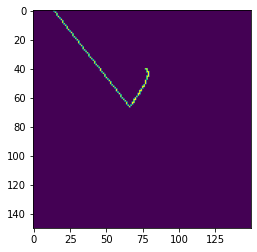

In [21]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(tgt_img[5])

In [30]:
xy__ = states_feat[5][:,:2]*width/2
xy__
# plt.plot(xy__[0],xy__[1])

array([[ 8.80187988e+01,  2.73596191e+03],
       [ 9.49401855e+01,  2.73087158e+03],
       [ 1.03234863e+02,  2.72396851e+03],
       [ 1.13104248e+02,  2.71604004e+03],
       [ 1.24218750e+02,  2.70726929e+03],
       [ 1.36358643e+02,  2.69749146e+03],
       [ 1.49176025e+02,  2.68577271e+03],
       [ 1.62762451e+02,  2.67324829e+03],
       [ 1.79498291e+02,  2.65861816e+03],
       [ 1.97277832e+02,  2.64028931e+03],
       [ 7.78237305e+01,  4.00725098e+01],
       [ 5.85232544e+03,  3.02424316e+03],
       [ 5.86503296e+03,  3.04484253e+03],
       [ 5.87880249e+03,  3.06573486e+03],
       [ 5.89182129e+03,  3.08957520e+03],
       [ 5.90326538e+03,  3.11407471e+03],
       [ 5.91342773e+03,  3.14018555e+03],
       [ 5.92188721e+03,  3.16803589e+03],
       [ 5.92846069e+03,  3.19714966e+03],
       [ 5.93336792e+03,  3.22946777e+03],
       [ 5.93703003e+03,  3.26334229e+03],
       [ 5.93759766e+03,  3.29450684e+03],
       [ 5.93662720e+03,  3.32684326e+03],
       [ 5.

In [ ]:
import matplotlib.pyplot as plt
dummy = empty_mask.copy()

states_pixel = xy_to_pixel(states_feat[:,10,:2]*(width/2),width)
[cv2.circle(dummy,tuple(xy.astype(np.int32)),radius=2,color=1,thickness=cv2.FILLED) for xy in states_pixel]

plt.figure()
plt.imshow(dummy)

plt.figure()
plt.imshow(drivable_area)

plt.figure()
plt.imshow(lanes)

In [ ]:
states_pixel.shape

In [ ]:
states_feat[:,10,:2]